### Cluster Analysis

In [1]:
# !pip3 install mesa

In [2]:
import numpy as np
import pandas as pd
import mesa
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

%matplotlib inline

### Agents

In [3]:
COMPLETED_STATUS = 'COMPLETED'
FAILED_STATUS = 'FAILED'
PENDING_STATUS = 'PENDING'
PROCESSING_STATUS = 'PROCESSING'

class Server(mesa.Agent):
    def __init__(self, unique_id, model, cpu, ram):
        super().__init__(unique_id, model)
        self.cpu = float(cpu)
        self.ram = ram
        self.tasks = {}
        self.failed_tasks = 0
        self.completed_tasks = 0
        self.reboots = 0

    def get_task_cpu(self):
        tasks_len = len(self.tasks)
        if tasks_len == 0:
            return self.cpu
        return self.cpu / tasks_len

    def get_free_ram(self):
        tasks_ram = 0
        for task in self.tasks.values():
            tasks_ram += task.ram
        return self.ram - tasks_ram

    def get_ram_usage(self):
        return "%.2f" % (1 - (self.get_free_ram() / self.ram))

    def reboot(self):
        self.failed_tasks = self.failed_tasks + len(self.tasks)
        self.reboots = self.reboots + 1
        self.tasks = {}

    def add_task(self, task):
        task.set_status(PROCESSING_STATUS)
        self.tasks[task.unique_id] = task
        
        if self.get_free_ram() < 0:
            self.reboot()

    def drop_task(self, task):
        if task.unique_id in self.tasks:
            self.tasks.pop(task.unique_id)

    def get_tasks_load(self):
        load = 0
        for task in self.tasks.values():
            load = load + task.load
        return load

    def step(self):
        to_drop = []
        for task in self.tasks.values():
            task.step()
            if task.status == COMPLETED_STATUS:
                to_drop.append(task.unique_id)
                self.completed_tasks = self.completed_tasks + 1
            if task.status == FAILED_STATUS:
                to_drop.append(task.unique_id)
                self.failed_tasks = self.failed_tasks + 1
        for tid in to_drop:
            self.tasks.pop(tid)


class Task(mesa.Agent):
    def __init__(self, unique_id, model, server, load, ram, steps_limit=5):
        super().__init__(unique_id, model)
        self.server = server
        self.status = PENDING_STATUS
        self.ram = ram
        self.load = load
        self.steps = 0
        self.steps_limit = steps_limit

    def set_status(self, status):
        self.status = status

    def calculate(self):
        self.load = self.load - self.server.get_task_cpu() * 0.1
        #print(self.server.get_task_cpu())
        #print("Task %s Load %.2f" % (self.unique_id, self.load))

    def step(self):
        self.calculate()
        self.steps = self.steps + 1
        if self.load <= 0:
            self.set_status(COMPLETED_STATUS)
            return
        if self.steps > self.steps_limit:
            self.set_status(FAILED_STATUS)

### Model

In [4]:
class Cluster(mesa.Model):
    def __init__(
        self,
        servers_cnt = 2,
        width=10,
        height=10,
        tasks_cnt = 10,
        server_cpu = 4,
        server_ram = 4
    ):
        super().__init__()
        self.schedule = mesa.time.RandomActivation(self)
        self.servers_cnt = servers_cnt
        self.tasks_cnt = tasks_cnt
        self.running_tasks = 0
        self.server_cpu = server_cpu
        self.server_ram = server_ram

        self.servers = []
        self.grid = mesa.space.MultiGrid(width, height, True)

        for i in range(servers_cnt):
            server = Server(i, self, self.server_cpu, self.server_ram)
            self.servers.append(server)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(server, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "CompletedTasks": lambda m: sum(s.completed_tasks for s in m.servers),
                "FailedTasks": lambda m: sum(s.failed_tasks for s in m.servers),
                "Reboots": lambda m: sum(s.reboots for s in m.servers)
            },
            agent_reporters = {
                # "ProcessingTasks": lambda s: len(s.tasks),
                "ServerCompletedTasks": lambda s: s.completed_tasks,
                "ServerFailedTasks": lambda s: s.failed_tasks,
                "ServerMemoryUsage %": lambda s: s.get_ram_usage(),
                "ServerReboots": lambda s: s.reboots
            }
        )

        for i in range(self.servers_cnt):
            self._add_task()

        for server in self.servers:
            self.schedule.add(server)

        self.running = True
        self.datacollector.collect(self)

    def _add_task(self):
        # randomize task params
        load = np.random.randint(1, 4)
        ram = np.random.randint(2) + np.random.random()
        steps_limit = np.random.randint(3, 8)

        # print("load %.2f; ram %.2f; steps_limit: %d" % (load, ram, steps_limit))
        
        self.running_tasks = self.running_tasks + 1
        least_loaded_server = max(self.servers, key=lambda s: s.get_free_ram())
        task = Task(self.running_tasks, self, least_loaded_server, load=load, ram=ram, steps_limit=steps_limit)
        least_loaded_server.add_task(task)
        x = self.random.randrange(self.grid.width)
        y = self.random.randrange(self.grid.height)
        self.grid.place_agent(task, (x, y))

    def _servers_tasks(self):
        cnt = 0
        for s in self.servers:
            cnt = cnt + len(s.tasks)
        return cnt

    def step(self):
        if self.running_tasks >= self.tasks_cnt:
            if self._servers_tasks() == 0:
                self.running = False
                return
        else:
            # add new task
            if np.random.random() > 0.5:
                self._add_task()
        
        self.schedule.step()
        self.datacollector.collect(self)

    def run_model(self):
        for i in range(10):
            self.step()

### Test Cluster model

In [5]:
cluster = Cluster(server_cpu=3, server_ram=2, servers_cnt=2, tasks_cnt=30)
for i in range(100):
    cluster.step()

In [6]:
df = cluster.datacollector.get_model_vars_dataframe()
df

,CompletedTasks,FailedTasks,Reboots
0,0,0,0
1,0,0,0
2,0,2,1
3,0,2,1
4,1,2,1
...,...,...,...
67,7,21,4
68,7,22,4
69,7,22,4
70,7,22,4


<Axes: >

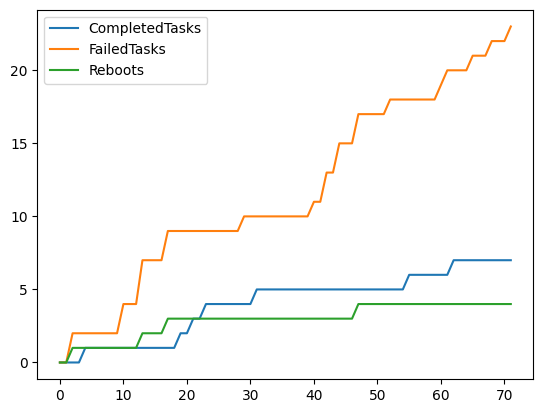

In [7]:
df.plot()

### Batch run

In [8]:
params = {
    "server_cpu": [2, 3, 4],
    "server_ram": [2, 3, 4], 
    "servers_cnt": [2, 3], 
    "tasks_cnt": [20, 30, 40]
}

results = mesa.batch_run(
    Cluster,
    parameters=params,
    iterations=1,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/54 [00:00<?, ?it/s]

In [9]:
results_df = pd.DataFrame(results)
results_df['completed'] = results_df['CompletedTasks'] / results_df['tasks_cnt']
results_df

,RunId,iteration,Step,server_cpu,server_ram,servers_cnt,tasks_cnt,CompletedTasks,FailedTasks,Reboots,AgentID,ServerCompletedTasks,ServerFailedTasks,ServerMemoryUsage %,ServerReboots,completed
0,0,0,0,2,2,2,20,0,0,0,0,0,0,0.59,0,0.000
1,0,0,0,2,2,2,20,0,0,0,1,0,0,0.97,0,0.000
2,0,0,1,2,2,2,20,0,0,0,0,0,0,0.59,0,0.000
3,0,0,1,2,2,2,20,0,0,0,1,0,0,0.97,0,0.000
4,0,0,2,2,2,2,20,0,0,0,0,0,0,0.59,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7912,53,0,74,4,4,3,40,13,26,0,1,5,9,0.23,0,0.325
7913,53,0,74,4,4,3,40,13,26,0,2,2,9,0.00,0,0.325
7914,53,0,75,4,4,3,40,13,26,0,0,6,8,0.00,0,0.325
7915,53,0,75,4,4,3,40,13,26,0,1,5,9,0.23,0,0.325


In [10]:
max_completed = results_df['completed'].max()
print(max_completed)

0.65


In [11]:
best_runs = results_df[results_df['completed'] >= max_completed * 0.8]['RunId'].unique()
print(best_runs)

[39 47 52]


In [12]:
def show_run(df):
    title = "Servers Count: %d, cpu: %.2f, ram: %.2f, tasks: %d" % (
        df.loc[0, 'servers_cnt'],
        df.loc[0, 'server_cpu'],
        df.loc[0, 'server_ram'],
        df.loc[0, 'tasks_cnt']
    )
    charts_df = df[['Step', 'CompletedTasks', 'FailedTasks', 'Reboots']].set_index('Step', drop=True)
    charts_df.plot(title=title)
    plt.show()

In [13]:
runs = results_df['RunId'].max()
slider = widgets.IntSlider(value=0, min=0, max=runs, step=1)
output = widgets.Output()

def handle_slider_change(change):
    with output:
        output.clear_output()
        #print(f"The new slider value is: {change.new}")
        show_run(results_df[results_df['RunId'] == change.new].reset_index())

slider.observe(handle_slider_change, 'value')

widgets.VBox([slider, output])